In [1]:
import numpy as np
import scipy.special
import cvxpy as cp
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from matplotlib.pyplot import plot

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

from src import QAOA_utilities as QAOAut
from src import CellFreeQAOA as CFQAOA

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [2]:
M = 3 # number of cells
K = 3 # number of users
rho = 1 # max power
BW_max =6 # max BW, M_hat in paper
rng = np.random.default_rng(270323)

Ntest = 40

In [3]:
# Hyperparameters
p = 2
lambda_0 = 10
tg = 10.0 ** np.array([ -3, -2.8 , -2.5, -2.3 , -2.2, -2.0 , -1.8, -1.6 , -1.5, -1, -0.5]) # for fine greed experiment
tg = 10.0 ** np.array([ -3, -2.5, -2.2, -1.8 , -1.5, -1, -0.5]) # for 16 qubits experiment

In [4]:
def compute_avg_QAOA_error( p, lambda_0, tg, M, K, BW_max, rho, Ntest, rng = np.random.default_rng(2744) ):

    e_vec = np.zeros(Ntest)
    
    for i in range(Ntest):

        eta = rng.random(K) # power control fraction for each user TO BE OTPIMIZED
        alpha = rng.random((M,K))
        beta = rng.random((M,K))
        X_QAOA, t_QAOA, xt_QAOA = CFQAOA.optimize_links(BW_max, rho, eta, alpha, beta, 1, lambda_0, tg, p)
        X_opt , t_opt = CFQAOA.bruteforce_SINR(M, K, BW_max, eta, alpha, beta, rho)

        QAOA_snr = min(CFQAOA.SINR( X_QAOA, eta, alpha, beta, rho ))
        OPT_snr = min(CFQAOA.SINR( X_opt, eta, alpha, beta, rho ))
        
        e_vec[i] = abs( QAOA_snr - OPT_snr )/OPT_snr # normalized absolute error
    
    return(e_vec)
    

In [5]:
def build_H(rho, eta, alpha, beta, lambda_0, tg ):
    
    M, K = beta.shape[0], beta.shape[1]
    MK = M*K
    Nt = len(tg)

    # Build auxiliary matrices
    Pt = np.concatenate((np.zeros((Nt,M*K)),np.eye(Nt)), axis = 1)
    Pk_list = []
    for k in range(K):
        Pk = np.concatenate((np.zeros((M,M*k)), np.eye(M), np.zeros((M,M*(K-k-1)+Nt))), axis = 1 )
        Pk_list.append(Pk)
    Pm_list = []
    for m in range(M):
        Pm = np.zeros((K,M*K+Nt))
        for k in range(K):
            Pm[k,m+M*k] = 1
        Pk_list.append(Pm)

    one_vec = np.ones(M*K+Nt)
    one_vec_tilde = np.concatenate((np.ones(M*K),np.zeros(Nt)))

    # build A and B

    A_list = []
    B_list = []
    C_list = []
    cbar_list = []
    ctilde_list = []

    b_tilde_list = []
    A_tilde_list = []

    for k in range(K):
        A_tilde = np.zeros((M,M))
        b_tilde = np.zeros(M)

        for m in range(M):
            for n in range(M):
                A_tilde[m,n] = rho*eta[k]*alpha[m,k]*alpha[n,k]
            b_tilde[m] = alpha[m,k]*(rho*(np.sum(np.multiply(eta,beta[m,:])) - beta[m,k]*eta[k]) + 1)

        A_tilde_list.append(A_tilde)
        b_tilde_list.append(b_tilde)

        A_list.append( Pk_list[k].T@A_tilde@Pk_list[k] )
        B_list.append( np.outer((Pt.T @ tg),(b_tilde.T @ Pk_list[k])) )

        C_list.append( A_list[k] - B_list[k])
        cbar_list.append( np.sum(C_list[k],0) )
        ctilde_list.append( np.sum(C_list[k],1) )
    
    lambda_s = np.zeros(K)
    for k in range(K):
        lambda_s[k] = lambda_0/max([np.trace(C_list[k]), 10**(-3) ])
    
    
    Hp = np.zeros((2**(MK+Nt),2**(MK+Nt)))
    Z_list = (MK+Nt) * [np.eye(2**(MK+Nt))]
    for i in range(MK+Nt):
        Ei = np.zeros((2**(MK+Nt),2**(MK+Nt)))
        if(i == 0):
            Ei[2**(i),2**(i)]=2
        else:
            Ei[2**(i)+1,2**(i)+1]=2
        Z_list[i] = Z_list[i] - Ei
        
    pen = K*[np.zeros((2**(MK+Nt),2**(MK+Nt)))]
    Hp = 0.5 * sum(Z_list[MK+1:])
    for k in range(K):
        for i in range(MK+Nt):
            for j in range(MK+Nt):
                pen[k] += C_list[k][i,j]*(Z_list[i]@Z_list[j])
            pen[k] += - (cbar_list[k][i] + ctilde_list[k][i])*Z_list[i] 
        pen[k] = lambda_s[k]*pen[k]
        Hp += -0.25*pen[k]
    
    return(Hp)

In [6]:
def print_objective(xstr, rho, eta, alpha, beta, lambda_0, tg ):
    M, K = beta.shape[0], beta.shape[1]
    MK = M*K
    Nt = len(tg)

    # Build auxiliary matrices
    Pt = np.concatenate((np.zeros((Nt,M*K)),np.eye(Nt)), axis = 1)
    Pk_list = []
    for k in range(K):
        Pk = np.concatenate((np.zeros((M,M*k)), np.eye(M), np.zeros((M,M*(K-k-1)+Nt))), axis = 1 )
        Pk_list.append(Pk)
    Pm_list = []
    for m in range(M):
        Pm = np.zeros((K,M*K+Nt))
        for k in range(K):
            Pm[k,m+M*k] = 1
        Pk_list.append(Pm)

    one_vec = np.ones(M*K+Nt)
    one_vec_tilde = np.concatenate((np.ones(M*K),np.zeros(Nt)))

    # build A and B

    A_list = []
    B_list = []
    C_list = []
    cbar_list = []
    ctilde_list = []

    b_tilde_list = []
    A_tilde_list = []

    for k in range(K):
        A_tilde = np.zeros((M,M))
        b_tilde = np.zeros(M)

        for m in range(M):
            for n in range(M):
                A_tilde[m,n] = rho*eta[k]*alpha[m,k]*alpha[n,k]
            b_tilde[m] = alpha[m,k]*(rho*(np.sum(np.multiply(eta,beta[m,:])) - beta[m,k]*eta[k]) + 1)

        A_tilde_list.append(A_tilde)
        b_tilde_list.append(b_tilde)

        A_list.append( Pk_list[k].T@A_tilde@Pk_list[k] )
        B_list.append( np.outer((Pt.T @ tg),(b_tilde.T @ Pk_list[k])) )

        C_list.append( A_list[k] - B_list[k] )
        
        cbar_list.append( np.sum(C_list[k],0) )
        ctilde_list.append( np.sum(C_list[k],1) )
    
    for k in range(K):
        for i in range(M*K+Nt):
            for j in range(M*K+Nt):
                C_list[k][i,j] = min(0,C_list[k][i,j])
      
        
    lambda_s = np.zeros(K)
    for k in range(K):
        lambda_s[k] = lambda_0/max([np.trace(C_list[k]), 10**(-3) ])
        
    
    return(sum(CFQAOA.problem_objective(xstr,tg,Pt,C_list,lambda_s, verbose = True)),CFQAOA.problem_objective(xstr,tg,Pt,C_list,lambda_s, verbose = True))

In [15]:
rng = np.random.default_rng(2745)
eta = rng.random(K) # power control fraction for each user TO BE OTPIMIZED
alpha = rng.random((M,K))
beta = rng.random((M,K))

lambda_0 = 0.008
tg = 10.0 ** np.array([ -3, -2.2, -1.5, -1, -0.5]) # for 16 qubits experiment
tg = np.array([0.11, 0.025, 0.25, 0.25])

#Hp=build_H(rho, eta, alpha, beta, lambda_0, tg )
X_QAOA, t_QAOA, xt_QAOA = CFQAOA.optimize_links(BW_max, rho, eta, alpha, beta, 1, lambda_0, tg, p)
X_opt , t_opt = CFQAOA.bruteforce_SINR(M, K, BW_max, eta, alpha, beta, rho)

#eigH = np.linalg.eig(Hp)
#iopt = np.argmin(eigH[0])
print('t_opt = ', t_opt)
print('t_QAOA = ', t_QAOA)
print('xt = ', xt_QAOA)
print('snr_QAOA = ', CFQAOA.SINR(X_QAOA, eta, alpha, beta, rho))
print('snr_opt = ', CFQAOA.SINR(X_opt, eta, alpha, beta, rho))
#print('min eig(H) = ', eigH[0][iopt], 'x min = ', eigH[1][iopt])
#print('eig(H): ', eigH[0])

----- Starting QAOA -----
COBYLA optimization result:  [0.83184282 1.55447863 0.42549274 1.46752122]
>>>> QAOA finds t = 0, while real is t =  0.05679952149426163  and min tg =  0.025
Optimal t =  0.05679952149426163
Optimal X =  [[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]]
----- Bruteforce Solution -----
MIN SINR:  0.11248570265028318
Best X:  [[1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]
Best 10 SINRs:  [0.1124857 0.1124857 0.1124857 0.1124857 0.1124857 0.1124857 0.1124857
 0.1124857 0.1124857 0.1124857]
t_opt =  0.11248570265028318
t_QAOA =  0.05679952149426163
xt =  [0. 0. 0. 0.]
snr_QAOA =  [0.07458479 1.15196003 0.05679952]
snr_opt =  [0.1124857  0.26730656 0.15482239]


In [12]:
def vec2bitstr(x, reverse = False):
    if reverse:
        x = x[::-1]
    
    xstr = ''
    for xi in x:
        if xi == 0:
            xstr += '0'
        else:       
            xstr += '1'
    
    return(xstr)

In [13]:
#xstr_QAOA = '1111100010011'
#xstr_opt = '0001100111010'



xt_opt = np.zeros(len(tg))
xt_opt[0] = 1
xstr_opt = vec2bitstr( np.concatenate((X_opt.flatten('F'), xt_opt)), reverse = True )   
print('xstr opt = ',xstr_opt)
xstr_QAOA = vec2bitstr( np.concatenate((X_QAOA.flatten('F'), xt_QAOA)), reverse = True )   
print('xstr QAOA = ', xstr_QAOA)


lambda_0 = 0.005
print('QAOA: ', print_objective(xstr_QAOA, rho, eta, alpha, beta, lambda_0, tg ))
print('OPT: ', print_objective(xstr_opt, rho, eta, alpha, beta, lambda_0, tg ) )

xstr opt =  00001100100111
xstr QAOA =  00110001111101
QAOA:  (-0.8252970672127271, (0.03793235004648572, -0.8632294172592129))
OPT:  (-0.022639800715137152, (0.001, -0.023639800715137153))


In [27]:
def compute_optimal_error( p, lambda_00, tg_0, M, K, BW_max, rho, Ntest, rng = np.random.default_rng(2744) ):
    
    e_vec = np.zeros(Ntest)
    eopt_vec = np.zeros(Ntest)   
    
    
    for i in range(Ntest):

        lambda_0 = lambda_00
        tg = tg_0
        # sample network parameters
        eta = rng.random(K) # power control fraction for each user TO BE OTPIMIZED
        alpha = rng.random((M,K))
        beta = rng.random((M,K))
        
        # exact solution
        X_opt , t_opt = CFQAOA.bruteforce_SINR(M, K, BW_max, eta, alpha, beta, rho)
        OPT_snr = min(CFQAOA.SINR( X_opt, eta, alpha, beta, rho ))
        
        # run QAOA
        X_QAOA, t_QAOA, xt_QAOA = CFQAOA.optimize_links(BW_max, rho, eta, alpha, beta, 1, lambda_0, tg, p)
        QAOA_snr = min(CFQAOA.SINR( X_QAOA, eta, alpha, beta, rho ))
        
        # compute error
        e_vec[i] = abs( QAOA_snr - OPT_snr )/OPT_snr # normalized absolute error
    
        # set hyperparameters artificially
        for j in range(1,K): 
            tg[j] = t_opt + 2*10**(-7)
        tg[0] = t_opt
        
        xt_opt = np.zeros(len(tg))
        xt_opt[0] = 1
        xstr = vec2bitstr( np.concatenate((X_opt.flatten('F'), xt_opt)), reverse=True )
        xstr_QAOA = vec2bitstr( np.concatenate((X_QAOA.flatten('F'), xt_QAOA)), reverse=True )
        
        #def obj(lambda_0):
            #return( print_objective(xstr, rho, eta, alpha, beta, lambda_0, tg )[0] - print_objective(xstr_QAOA, rho, eta, alpha, beta, lambda_0, tg )[0]  )
        
        #lb = {'type': 'ineq',
        # 'fun': lambda x: x-10**(-8)}
        #ub = {'type': 'ineq',
        # 'fun': lambda x: 10-x}
        
        #res = minimize(obj,lambda_0, method='COBYLA',constraints=[lb,ub])
        #lambda_0 = res.x
        
        gopt, [fopt, copt] = print_objective(xstr, rho, eta, alpha, beta, lambda_0, tg )
        gqaoa, [fqaoa, cqaoa] = print_objective(xstr_QAOA, rho, eta, alpha, beta, lambda_0, tg )
        
        df = fopt - fqaoa
        dc = copt - cqaoa
        sgnc = dc/abs(dc)
        print('Sign of dC = ', sgnc)
        lambda_0 = max([df/dc + sgnc*10**(-5), 10**(-5)])
        
        print('lambda_0 after optimization: ', lambda_0)
        
        X_QAOA, t_QAOA, xt_QAOA = CFQAOA.optimize_links(BW_max, rho, eta, alpha, beta, 1, lambda_0, tg, p)
        QAOA_snr = min(CFQAOA.SINR( X_QAOA, eta, alpha, beta, rho ))
        
        # compute error
        eopt_vec[i] = abs( QAOA_snr - OPT_snr )/OPT_snr # normalized absolute error
    
    
    return(e_vec, eopt_vec)

In [21]:
lambda_0 = 1
p = 4
tg = 10.0 ** np.array([ -3, -2.2, -1.5, -1, -0.5]) 
print(compute_optimal_error( p, lambda_0, tg, M, K, BW_max, rho, 6, rng = np.random.default_rng(2703) ))

----- Bruteforce Solution -----
MIN SINR:  0.000564663102721927
Best X:  [[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 1.]]
Best 10 SINRs:  [0.00056466 0.00056466 0.00056466 0.00056466 0.00056466 0.00056466
 0.00056466 0.00056466 0.00056466 0.00056466]
----- Starting QAOA -----
COBYLA optimization result:  [0.18266544 0.23735019 0.24013238 0.24383534 1.25036253 0.25376796
 0.25772034 0.24603013]
Optimal t =  0.0003259689213284133
Optimal X =  [[1. 0. 0.]
 [1. 0. 1.]
 [1. 1. 1.]]
Sign of dC =  -1.0
lambda_0 after optimization:  0.00034986552132471597
----- Starting QAOA -----
COBYLA optimization result:  [ 0.80606595  1.28266799  0.15500448  0.37550015  1.3110758   1.24950995
  0.06407014 -0.06364272]
Optimal t =  0.0003259689213284133
Optimal X =  [[0. 1. 0.]
 [0. 1. 1.]
 [1. 1. 1.]]
----- Bruteforce Solution -----
MIN SINR:  0.44298859912063177
Best X:  [[1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]
Best 10 SINRs:  [0.37219737 0.37219737 0.37219737 0.37219737 0.39742818 0.39742818
 0.39742818 0.4429886  0.44

In [5]:
p_vec = np.array([2,3,4,5,6,7,8])
p_vec = np.array([2,3,4,5])
ep_avg = np.zeros(len(p_vec))
ep_list = len(p_vec)*[np.zeros(Ntest)]

for it in range(len(p_vec)):
    ep_list[it] = compute_avg_QAOA_error( p_vec[it], lambda_0, tg, M, K, BW_max, rho, Ntest, rng = np.random.default_rng(2744) )
    ep_avg[it] = np.average(ep_list[it])

----- Starting QAOA -----
COBYLA optimization result:  [1.61984196 0.26610483 0.05777992 0.44258986]
Optimal t =  0.0400924804155823
Optimal X =  [[1. 1. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
Actual full search best

ID:  169
MIN SINR:  0.0954555655355017
Best X:  [[0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.14584115 1.47982549 1.53384646 0.70355427]
Optimal t =  0.07270654477838893
Optimal X =  [[1. 0. 0.]
 [1. 1. 1.]
 [0. 0. 1.]]
Actual full search best

ID:  143
MIN SINR:  0.173968693168226
Best X:  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [ 0.50074715 -0.06661227  0.05661594  0.44672796]
Optimal t =  0.0
Optimal X =  [[0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]]
Actual full search best

ID:  105
MIN SINR:  0.07882045930673753
Best X:  [[0. 0. 1.]
 [1. 0. 1.]
 [0. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.64459212 1.49848038 1.38269172 0.51324836]
Optimal t =  0.005778444015081

COBYLA optimization result:  [0.49326476 0.5113702  1.51454538 1.61210443]
Optimal t =  0.0
Optimal X =  [[1. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]]
Actual full search best

ID:  369
MIN SINR:  0.25754694408752626
Best X:  [[1. 1. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.32539975 0.04148556 0.43305331 0.43208526]
Optimal t =  0.08673942146706692
Optimal X =  [[0. 1. 1.]
 [0. 1. 0.]
 [1. 0. 1.]]
Actual full search best

ID:  379
MIN SINR:  0.2137908749715932
Best X:  [[1. 1. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.36430621 0.60718542 0.35587921 1.26382256]
>>>> QAOA finds t = 0, while real is t =  0.0  and min tg =  0.001
Optimal t =  0.0
Optimal X =  [[1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
Actual full search best

ID:  143
MIN SINR:  0.00010465921692016387
Best X:  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.49966446 0.59091614 0.41206934 0.50012232]
Opt

Optimal t =  0.19385997488990706
Optimal X =  [[0. 1. 1.]
 [0. 0. 1.]
 [1. 0. 1.]]
Actual full search best

ID:  47
MIN SINR:  0.2248259139863644
Best X:  [[0. 0. 0.]
 [1. 0. 1.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.30558259 0.34466722 0.32442354 0.42490241 0.09983376 1.33759687]
>>>> QAOA finds t = 0, while real is t =  0.0  and min tg =  0.001
Optimal t =  0.0
Optimal X =  [[1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]]
Actual full search best

ID:  149
MIN SINR:  0.2389006220770222
Best X:  [[0. 1. 0.]
 [0. 1. 1.]
 [1. 0. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [ 0.44084797  0.09582114  0.05738345  0.15460758  0.00353969 -0.03492418]
Optimal t =  0.14780454173702684
Optimal X =  [[0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]]
Actual full search best

ID:  368
MIN SINR:  0.2683901763117625
Best X:  [[1. 1. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.26569303 0.26066734 0.32244694 0.02750367 1.31125849 0.470359

Optimal t =  0.0
Optimal X =  [[1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]]
Actual full search best

ID:  150
MIN SINR:  0.1266243031421871
Best X:  [[0. 1. 0.]
 [0. 1. 1.]
 [1. 1. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.34640281 0.71226242 0.28791443 0.14826006 0.16467336 0.19289863
 0.20816849 0.08466638]
>>>> QAOA finds t = 0, while real is t =  0.023357233071072857  and min tg =  0.001
Optimal t =  0.023357233071072857
Optimal X =  [[1. 1. 1.]
 [1. 0. 0.]
 [0. 0. 0.]]
Actual full search best

ID:  169
MIN SINR:  0.0954555655355017
Best X:  [[0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [ 1.31722702  0.17696104 -0.02547474  0.08533128  0.02994485  0.06940635
  0.23294803  0.07638976]
Optimal t =  0.0
Optimal X =  [[1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]]
Actual full search best

ID:  143
MIN SINR:  0.173968693168226
Best X:  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [ 1.27048206  

COBYLA optimization result:  [0.41086252 0.37172873 0.38058294 0.26530843 0.07934762 0.12811079
 0.28260851 0.22581878]
Optimal t =  0.1409398808888333
Optimal X =  [[0. 1. 1.]
 [1. 0. 1.]
 [0. 1. 0.]]
Actual full search best

ID:  354
MIN SINR:  0.3482825910500816
Best X:  [[1. 1. 0.]
 [1. 0. 1.]
 [1. 0. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.1521208  0.27805606 0.2171927  0.37584927 0.05511847 0.24142821
 0.2363802  1.24329237]
>>>> QAOA finds t = 0, while real is t =  0.07988553416285724  and min tg =  0.001
Optimal t =  0.07988553416285724
Optimal X =  [[1. 0. 1.]
 [1. 1. 0.]
 [0. 1. 0.]]
Actual full search best

ID:  349
MIN SINR:  0.107768723409618
Best X:  [[1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.39302659 0.52771368 0.2214238  0.22345402 0.16326554 0.21045718
 0.22473573 0.1532396 ]
>>>> QAOA finds t = 0, while real is t =  0.0  and min tg =  0.001
Optimal t =  0.0
Optimal X =  [[0. 0. 1.]
 [0. 1. 1.]


Optimal t =  0.007505840985897225
Optimal X =  [[0. 1. 0.]
 [1. 1. 1.]
 [0. 1. 0.]]
Actual full search best

ID:  143
MIN SINR:  0.007505840985897225
Best X:  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.40171634 0.18893047 0.46942751 0.1691268  0.2115498  0.11079396
 0.07957354 0.12907615 0.17493627 0.16826407]
Optimal t =  0.0
Optimal X =  [[0. 0. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]
Actual full search best

ID:  234
MIN SINR:  0.14957321370006768
Best X:  [[1. 0. 0.]
 [0. 0. 1.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [ 0.24819238  0.1177847   0.28926727  0.28622937  0.18366658  0.07769779
 -0.01126079  0.05469046  0.31214372  0.20285899]
Optimal t =  0.19641959502662967
Optimal X =  [[0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]]
Actual full search best

ID:  143
MIN SINR:  0.19641959502662967
Best X:  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.32798463 0.46805874 0.411994

>>>> QAOA finds t = 0, while real is t =  0.0  and min tg =  0.001
Optimal t =  0.0
Optimal X =  [[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 1.]]
Actual full search best

ID:  257
MIN SINR:  0.08283879753679213
Best X:  [[1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.39368583 0.53223427 0.16697588 0.18336707 0.37379169 0.11439143
 0.22017519 0.17684695 0.09602362 0.20054216]
>>>> QAOA finds t = 0, while real is t =  0.13137765351109398  and min tg =  0.001
Optimal t =  0.13137765351109398
Optimal X =  [[1. 0. 0.]
 [0. 0. 1.]
 [1. 1. 0.]]
Actual full search best

ID:  369
MIN SINR:  0.25754694408752626
Best X:  [[1. 1. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.58053644 0.38839064 0.21643078 0.27197459 0.15654855 0.09859396
 0.21864535 0.1301224  0.10038673 0.2083984 ]
>>>> QAOA finds t = 0, while real is t =  0.08673942146706692  and min tg =  0.001
Optimal t =  0.08673942146706692
Optimal X =  [[0. 1. 1.]
 

[0.59650899 0.54840254 0.5552756  0.55121278]


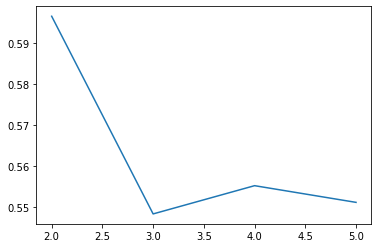

In [6]:
print(ep_avg)
plot(p_vec, ep_avg)

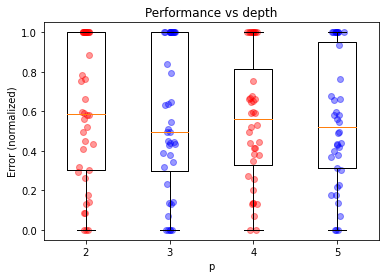

In [11]:
vals, names, xs = [],[],[]
for i in range(len(ep_list)):
    vals.append(ep_list[i])
    names.append(p_vec[i])
    xs.append(np.random.normal(p_vec[i]-1, 0.04, Ntest))

plt.boxplot(vals, labels=names)
palette = len(p_vec)//2 * ['r', 'b']
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.4, color=c)
plt.xlabel('p')
plt.ylabel('Error (normalized)')
plt.title('Performance vs depth')
plt.show()

In [8]:
lambda_vec = [1/10, 1/2, 2, 10]
el_avg = np.zeros(len(lambda_vec))
el_list = len(p_vec)*[np.zeros(Ntest)]

for it in range(len(lambda_vec)):
    el_list[it] = compute_avg_QAOA_error( p, lambda_vec[it], tg, M, K, BW_max, rho, Ntest, rng = np.random.default_rng(2744) )
    el_avg[it] = np.average(el_list[it])

----- Starting QAOA -----
COBYLA optimization result:  [0.9958075  0.46292309 1.50979457 1.52975426]
Optimal t =  0.0954555655355017
Optimal X =  [[0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]]
Actual full search best

ID:  169
MIN SINR:  0.0954555655355017
Best X:  [[0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.280095   0.69643006 1.450572   1.36651205]
Optimal t =  0.07270654477838893
Optimal X =  [[1. 0. 0.]
 [0. 1. 1.]
 [1. 0. 0.]]
Actual full search best

ID:  143
MIN SINR:  0.173968693168226
Best X:  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.59651174 0.32702733 1.49814103 1.65821092]
Optimal t =  0.016981093403000514
Optimal X =  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
Actual full search best

ID:  105
MIN SINR:  0.07882045930673753
Best X:  [[0. 0. 1.]
 [1. 0. 1.]
 [0. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.3310638  0.06402749 0.34329827 0.43837492]
Optimal t =  0.0


COBYLA optimization result:  [0.4587976  0.9759286  1.73424742 1.32873897]
Optimal t =  0.1374600076844341
Optimal X =  [[1. 0. 1.]
 [1. 1. 0.]
 [0. 1. 0.]]
Actual full search best

ID:  369
MIN SINR:  0.25754694408752626
Best X:  [[1. 1. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.22003884 0.4202359  0.4524771  1.73889876]
Optimal t =  0.0995818129861336
Optimal X =  [[0. 0. 1.]
 [1. 1. 0.]
 [0. 0. 1.]]
Actual full search best

ID:  379
MIN SINR:  0.2137908749715932
Best X:  [[1. 1. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.400301   0.41750625 0.22901937 0.29954256]
Optimal t =  2.2779377313591524e-05
Optimal X =  [[0. 1. 1.]
 [1. 0. 0.]
 [1. 0. 1.]]
Actual full search best

ID:  143
MIN SINR:  0.00010465921692016387
Best X:  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.44890957 0.43528276 0.48579493 1.35985881]
Optimal t =  0.0
Optimal X =  [[0. 0.

COBYLA optimization result:  [0.50304721 0.57236569 1.67427063 1.51117529]
Optimal t =  0.14780454173702684
Optimal X =  [[1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 1.]]
Actual full search best

ID:  368
MIN SINR:  0.2683901763117625
Best X:  [[1. 1. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.44569414 0.47965396 0.31963759 0.49517713]
Optimal t =  0.01774505320364593
Optimal X =  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
Actual full search best

ID:  308
MIN SINR:  0.04075244352588611
Best X:  [[1. 0. 1.]
 [1. 0. 0.]
 [1. 1. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.43871924 0.5142189  1.81671465 1.54472527]
Optimal t =  0.3482254576548481
Optimal X =  [[1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 1.]]
Actual full search best

ID:  329
MIN SINR:  0.41970594934163324
Best X:  [[1. 1. 0.]
 [0. 0. 1.]
 [0. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.58669058 0.32113599 1.64089679 1.61422726]
Optimal t =  0.0
Optimal X =  [[0. 0. 1.]


COBYLA optimization result:  [0.72053956 0.23518686 0.27703105 1.21873671]
>>>> QAOA finds t = 0, while real is t =  0.006611144094821783  and min tg =  0.001
Optimal t =  0.006611144094821783
Optimal X =  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
Actual full search best

ID:  117
MIN SINR:  0.12175023153060126
Best X:  [[0. 0. 1.]
 [1. 1. 1.]
 [0. 0. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.56589397 0.16463998 0.41887847 0.66544315]
Optimal t =  0.0018850653979224396
Optimal X =  [[1. 0. 0.]
 [1. 1. 1.]
 [1. 0. 0.]]
Actual full search best

ID:  143
MIN SINR:  0.007505840985897225
Best X:  [[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.48756032 0.26535307 0.55372609 1.77465594]
>>>> QAOA finds t = 0, while real is t =  0.0  and min tg =  0.001
Optimal t =  0.0
Optimal X =  [[0. 1. 1.]
 [0. 0. 1.]
 [0. 1. 1.]]
Actual full search best

ID:  234
MIN SINR:  0.14957321370006768
Best X:  [[1. 0. 0.]
 [0. 0. 1.]
 [1. 1. 1.]]
--

COBYLA optimization result:  [0.52223652 0.21279754 0.50089171 1.71669604]
Optimal t =  0.08657475623065941
Optimal X =  [[0. 1. 1.]
 [0. 0. 1.]
 [1. 0. 1.]]
Actual full search best

ID:  78
MIN SINR:  0.1710610771901329
Best X:  [[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.69787072 0.38728679 0.3461434  0.58811577]
Optimal t =  0.09571577864078443
Optimal X =  [[0. 1. 0.]
 [1. 0. 1.]
 [1. 0. 1.]]
Actual full search best

ID:  93
MIN SINR:  0.2085876312479953
Best X:  [[0. 0. 1.]
 [0. 1. 1.]
 [1. 1. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.74248603 0.42857705 0.25450052 0.47839492]
Optimal t =  0.06484824592282906
Optimal X =  [[0. 1. 0.]
 [1. 0. 1.]
 [1. 0. 1.]]
Actual full search best

ID:  150
MIN SINR:  0.1923174805109401
Best X:  [[0. 1. 0.]
 [0. 1. 1.]
 [1. 1. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.32620259 0.61038726 0.10587534 0.35010716]
Optimal t =  0.057142132419953466
Optimal X =

Optimal t =  0.03072823073385613
Optimal X =  [[1. 1. 0.]
 [0. 1. 1.]
 [1. 0. 0.]]
Actual full search best

ID:  198
MIN SINR:  0.07015911924512983
Best X:  [[0. 1. 1.]
 [0. 1. 0.]
 [1. 1. 0.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.34069403 0.24695074 0.05559637 0.4009875 ]
>>>> QAOA finds t = 0, while real is t =  0.0  and min tg =  0.001
Optimal t =  0.0
Optimal X =  [[0. 1. 1.]
 [0. 1. 0.]
 [0. 1. 1.]]
Actual full search best

ID:  257
MIN SINR:  0.10956228357304679
Best X:  [[1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [1.51018916 0.27845523 0.20653409 0.31612407]
Optimal t =  0.19336333013905088
Optimal X =  [[1. 1. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]
Actual full search best

ID:  336
MIN SINR:  0.2231735028690366
Best X:  [[1. 1. 0.]
 [0. 1. 0.]
 [0. 1. 1.]]
----- Starting QAOA -----
COBYLA optimization result:  [0.57267844 0.28499321 0.13456426 0.54758212]
>>>> QAOA finds t = 0, while real is t =  0.19707699624714087  an

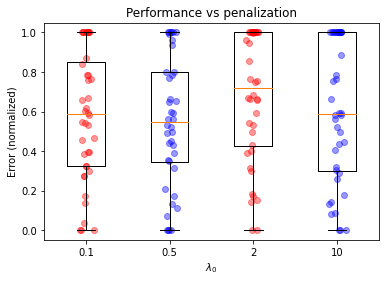

In [15]:
vals, names, xs = [],[],[]
for i in range(len(lambda_vec)):
    vals.append(el_list[i])
    names.append(lambda_vec[i])
    xs.append(np.random.normal(i+1, 0.04, Ntest))

plt.boxplot(vals, labels=names)
palette = len(p_vec)//2 * ['r', 'b']
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.4, color=c)
plt.xlabel('$\lambda_0$')
plt.ylabel('Error (normalized)')
plt.title('Performance vs penalization')
plt.show()

In [19]:
# Saving to a file
err_mat_p = np.zeros((len(p_vec),Ntest))
for i in range(len(p_vec)):
    err_mat_p[i,:] = ep_list[i] 

#np.savetxt('PerformanceVSDepth_ErrorMatrix_Ntest40.csv', err_mat_p, delimiter=",")

err_mat_l = np.zeros((len(lambda_vec),Ntest))
for i in range(len(lambda_vec)):
    err_mat_l[i,:] = el_list[i] 

#np.savetxt('PerformanceVSPenalty_ErrorMatrix_Ntest40.csv', err_mat_l, delimiter=",")
